<a href="https://colab.research.google.com/github/coldfir3/Kaggle-NFL-helmet/blob/main/%5BNFL_Helmet%5D_Siamese_network_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial Setup

In [1]:
import sys
import os
is_colab = 'google.colab' in sys.modules
!nvidia-smi

Fri Aug 27 17:20:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Installing packages

In [2]:
if is_colab:
    !pip install -Uqqq wandb
    !pip install -Uqqq fastai
    !pip install -Uqqq timm

### Loading packages

In [3]:
from fastai.vision.all import *
import wandb
from fastai.callback.wandb import *
import timm

### Downloading data



In [4]:
wandb.Api()
if is_colab:

    from google.colab import drive
    from os.path import exists

    if not exists('/content/drive'):
        drive.mount('/content/drive')
    %run '/content/drive/MyDrive/Kaggle/My Kaggle [colab].ipynb'

    if not exists('/content/sideline'):
        setup_kaggle()
        get_kaggle_data('d', 'coldfir3/nflhelmet-path-dataset')

## Datablock & Dataloaders

In [5]:
path_side = Path('/content/sideline')
path_track = Path('/content/tracking')
imgs_side = get_image_files(path_side)
imgs_track = get_image_files(path_track)
game_plays = L(set(['_'.join(x.stem.split('_')[:-1]) for x in imgs_track]))
games = L(set(['_'.join(x.stem.split('_')[:-2]) for x in imgs_track]))

In [6]:
class ImageTuple(fastuple):
    @classmethod
    def create(cls, fns): return cls(tuple(PILImageBW.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        if 'cmap' not in kwargs:
            kwargs['cmap'] = 'gray' 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 2)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

def ImageTupleBlock(): return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)

@typedispatch
def show_batch(x:ImageTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

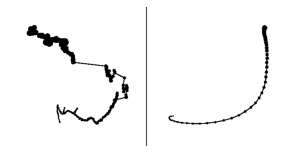

In [7]:
img = ImageTuple.create((imgs_side[0], imgs_track[0]))
img = ToTensor()(img)
img.show();

In [8]:
splits = RandomSplitter(seed=42)(games)
splits_files = [L([f for f in imgs_side if f.stem.split('_')[0] in games[s]]) for s in splits]
splits_sets = mapped(set, splits_files)
splits_files

[(#1056) [Path('/content/sideline/57584_000336_V26.png'),Path('/content/sideline/57993_000475_H93.png'),Path('/content/sideline/57597_001242_V26.png'),Path('/content/sideline/58093_001923_H59.png'),Path('/content/sideline/57782_000600_H6.png'),Path('/content/sideline/58094_000423_H21.png'),Path('/content/sideline/57680_002206_H11.png'),Path('/content/sideline/57679_003316_H93.png'),Path('/content/sideline/57679_003316_V18.png'),Path('/content/sideline/58102_002798_V78.png')...],
 (#264) [Path('/content/sideline/58103_003494_H38.png'),Path('/content/sideline/58103_003494_V73.png'),Path('/content/sideline/57786_003085_V88.png'),Path('/content/sideline/58095_004022_H78.png'),Path('/content/sideline/57997_003691_V42.png'),Path('/content/sideline/57905_002404_V18.png'),Path('/content/sideline/58095_004022_V22.png'),Path('/content/sideline/57784_001741_H40.png'),Path('/content/sideline/57907_003615_H24.png'),Path('/content/sideline/57786_003085_H96.png')...]]

In [9]:
def get_split(f):
    for i,s in enumerate(splits_sets):
        if f in s: return i
    raise ValueError(f'File {f} is not presented in any split.')

game_play2files = [{l: [f for f in s if '_'.join(f.stem.split('_')[:-1]) == l] for l in game_plays} for s in splits_sets]

def splitter(items): 
    def get_split_files(i): return [j for j,(f1,f2,same) in enumerate(items) if get_split(f1)==i]
    return get_split_files(0),get_split_files(1)

def draw_other(f):
    same = random.random() < 0.5
    split = get_split(f)
    game_play = '_'.join(f.stem.split('_')[:-1])
    if same:
        return path_track / f.name, same
    else:
        possible_draws = [path_track / ff.name for ff in game_play2files[split][game_play] if ff != f]
        return random.choice(possible_draws), same

def get_tuples(files): return [[f, *draw_other(f)] for f in files]

def get_x(t): return t[:2]
def get_y(t): return t[2]

In [10]:
siamese = DataBlock(
    blocks=(ImageTupleBlock, CategoryBlock),
    get_items=get_tuples,
    get_x=get_x, get_y=get_y,
    splitter=splitter,
    item_tfms=[Resize(256), DihedralItem()],
    batch_tfms=aug_transforms(size = 224)
)

dls = siamese.dataloaders(imgs_side, bs = 8)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


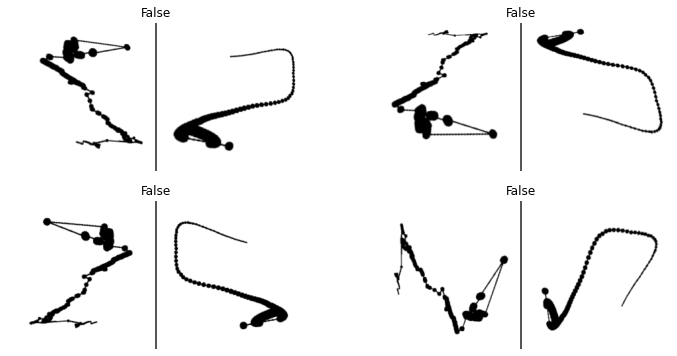

In [11]:
dls.show_batch(max_n = 4)

## Training the model

In [12]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x):
        x1, x2 = x
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [13]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [14]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [15]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x):
        x1, x2 = x
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

def create_timm_model_siamese(**cfg):
    model_name = cfg.pop('arch')
    img_size = cfg.pop('img_size')

    body = timm.create_model(model_name, True, num_classes = 0, **cfg)
    nf = body(torch.randn((2, cfg['in_chans'], img_size,img_size))).shape[-1]
    # head = nn.Linear(2*nf, 1)
    head = create_head(nf*2, 2, ps=0.5)
    model = SiameseModel(body, head)

    return model

def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [16]:
model = create_timm_model_siamese(**{
    'arch':'vit_small_patch16_224',
    'img_size':224,
    'in_chans' : 1, 
})

In [22]:
encoder = timm.create_model('seresnet152d', True, num_classes = 0, in_chans = 1, global_pool='')
# encoder = timm.create_model('vit_small_patch16_224', True, num_classes = 0, in_chans = 1)
head = create_head(2048*2, 2, lin_ftrs=[1024,512], ps=0.5)
model = SiameseModel(encoder, head)

In [23]:
learn = Learner(dls, model, loss_func=loss_func, splitter=siamese_splitter, metrics=accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.00013182566908653826)

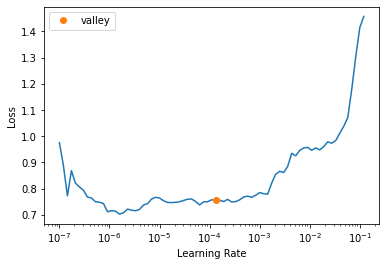

In [19]:
learn.freeze()
learn.lr_find()

In [ ]:
learn.fine_tune(25, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.827568,0.932434,0.511364,01:11


epoch,train_loss,valid_loss,accuracy,time
0,0.802021,0.965408,0.465909,01:33
1,0.808746,0.826536,0.511364,01:33
2,0.847004,0.938116,0.492424,01:33
3,0.783141,0.925677,0.515152,01:33
4,0.797031,0.871696,0.526515,01:33
5,0.787354,0.914654,0.518939,01:33
6,0.816605,0.849248,0.515152,01:33
7,0.777565,1.432015,0.496212,01:33
8,0.772735,0.967504,0.481061,01:33
9,0.760550,0.841153,0.518939,01:33
